In [1]:
import os
import sys
import shutil
import warnings
import numpy as np
import cv2
from tqdm import tqdm_notebook
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('..')
warnings.simplefilter('ignore')

from keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.utils import Sequence
from keras.layers import Conv2D, Lambda
from keras.regularizers import l2
import keras.backend as K
import tensorflow as tf

from albumentations import (
    Compose, OneOf, Rotate,
    RandomBrightness, IAAAdditiveGaussianNoise, GaussNoise,
    OpticalDistortion, GridDistortion, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, HueSaturationValue,
    HorizontalFlip, Normalize, RandomGamma, RGBShift,
    Blur, MedianBlur, CLAHE, ToGray, JpegCompression,
    RandomSizedCrop
)

from segmentation_models.losses import dice_loss

from pascal_voc_data import PascalVocGenerator
from utils import *

from model import build_bn

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
height = 256
width = 256
num_classes = len(PascalVocGenerator.classes)
repeat_num = 1
batch_size = 20
epoch_nums = 300

train_aug = Compose([
    OneOf([
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ], p=0.5),
    OneOf([
        GaussNoise(),
        HueSaturationValue(),
        RGBShift()
    ], p=0.5),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        Blur(),
        MedianBlur()
    ], p=0.4),
    OneOf([
        CLAHE(),
        ToGray(),
        JpegCompression()
    ], p=0.2),
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
])

val_aug = Compose([
])

logdir = os.path.join('logs', '{}_epochs_{}_bs_{}x{}'.format(epoch_nums, batch_size, height, width))
if os.path.exists(logdir):
    shutil.rmtree(logdir)
os.makedirs(logdir)
os.path.join(os.getcwd()[13:], logdir)

'neural_networks/ICNet/logs/300_epochs_20_bs_256x256'

In [3]:
train_generator_aug = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/train70.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), True, train_aug, repeat_num
)
val_generator_aug = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/val30.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), True, val_aug, 1
)

class modify_gen(Sequence):
    def __init__(self, gen):
        self.gen = gen
        
    def __len__(self):
        return self.gen.__len__()
        
    def __getitem__(self, idx):
        x, y = self.gen[idx]
        y_scale_4 = np.array([cv2.resize(_y, (height // 4, width // 4), cv2.INTER_NEAREST) for _y in y])
        y_scale_8 = np.array([cv2.resize(_y, (height // 8, width // 8), cv2.INTER_NEAREST) for _y in y])
        y_scale_16 = np.array([cv2.resize(_y, (height // 16, width // 16), cv2.INTER_NEAREST) for _y in y])
        return x, [y_scale_4, y_scale_8, y_scale_16]

train_gen = modify_gen(train_generator_aug)
val_gen = modify_gen(val_generator_aug)

In [4]:
class PolyDecay:
    def __init__(self, initial_lr, power, n_epochs):
        self.initial_lr = initial_lr
        self.power = power
        self.n_epochs = n_epochs
    
    def scheduler(self, epoch):
        return self.initial_lr * np.power(1.0 - 1.0*epoch/self.n_epochs, self.power)

In [5]:
def reduce_lr(epoch, lr):
    if epoch % 20 == 0 and epoch > 0:
        return lr * 0.5
    else:
        return lr

lr = 0.001
decay = 0.9
optim = Adam(lr=lr)
lr_decay = LearningRateScheduler(PolyDecay(lr, decay, epoch_nums).scheduler)
# lr_decay = LearningRateScheduler(reduce_lr)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model_mappilary = build_bn(width=width, height=height, n_classes=256, train=True, weights_path='weights.h5')
out = Conv2D(num_classes, 1, activation='softmax', name='conv6_cls')(model_mappilary.get_layer('sub12_sum_interp').output)
aux_1 = Conv2D(num_classes, 1, activation='softmax', name='sub4_out')(model_mappilary.get_layer('conv5_4_interp').output)
aux_2 = Conv2D(num_classes, 1, activation='softmax', name='sub24_out')(model_mappilary.get_layer('sub24_sum_interp').output)
model = Model(inputs=model_mappilary.input, outputs=[out, aux_2, aux_1])

In [7]:
for layer in model.layers:
    if isinstance(layer, Conv2D):
        layer.kernel_regularizer = l2()

In [8]:
model.compile(optim, loss='categorical_crossentropy', loss_weights=[1.0, 0.4, 0.16], metrics=['categorical_accuracy'])

In [ ]:
history = model.fit_generator(
    train_gen, validation_data=val_gen,
    epochs=epoch_nums, verbose=1,
    callbacks=[
        TensorBoard(log_dir=logdir, batch_size=batch_size, write_graph=False, write_images=True),
#         EarlyStopping(patience=15, restore_best_weights=True)
        lr_decay
    ],
    workers=10, max_queue_size=25
)

In [13]:
upsample = Lambda(lambda x: tf.image.resize_bilinear(x, size=(int(x.shape[1])*4, int(x.shape[2])*4)), name='predictions')(out)
model_pred = Model(inputs=model.input, outputs=[upsample])

In [33]:
model_pred.save('141_epochs_fine_tuning.h5')

In [2]:
K.set_learning_phase(0)
model_pred = load_model(
    '141_epochs_fine_tuning.h5', custom_objects={
        'tf': tf
    }
)
model_pred.inputs, model_pred.outputs

Instructions for updating:
Colocations handled automatically by placer.


([<tf.Tensor 'image:0' shape=(?, 256, 256, 3) dtype=float32>],
 [<tf.Tensor 'predictions/ResizeBilinear:0' shape=(?, 256, 256, 21) dtype=float32>])

In [ ]:
iou = []
for img, true_mask in tqdm_notebook(val_generator_aug):
    pred = model_pred.predict(img)
    for i in range(len(pred)):
        pred_mask = softmax2classes(pred[i], height=height, width=width)
        iou.append(get_iou(true_mask[i], pred_mask)[0])
    break
np.mean(iou)

`300_epochs_early_stopping` -- 0.067378  
`141_pretrained` -- 0.122425  
`110_pretrained_dice_loss` -- 0.0649  
`41_pretrained` -- 0.098

0.009410009610847175


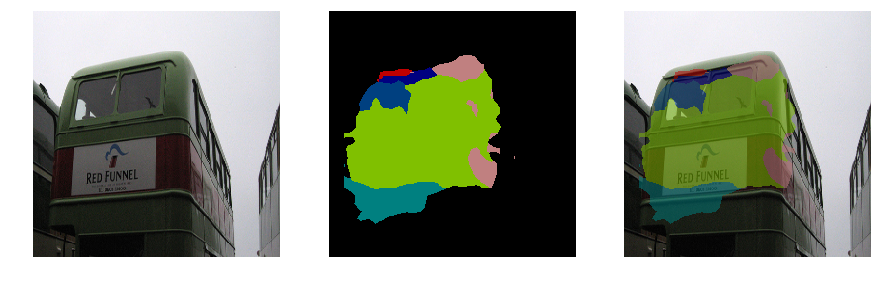

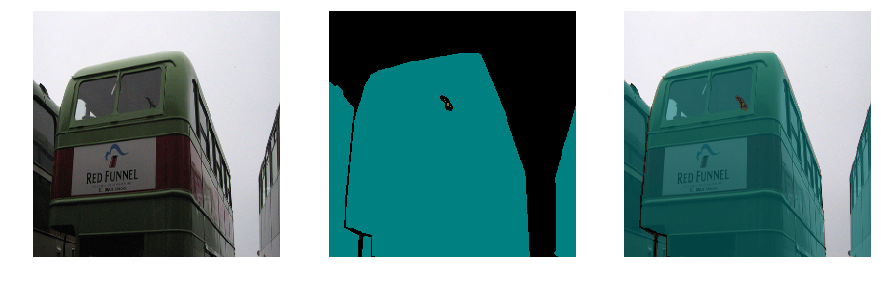

In [8]:
image_num = 10
pred_mask = softmax2classes(pred[image_num])
print(get_iou(true_mask[image_num], pred_mask)[0])
pred_mask_color = train_generator_aug.categorical_to_mask(pred_mask)
true_mask_color = train_generator_aug.categorical_to_mask(true_mask[image_num])
PascalVocGenerator.segmentation_plot(img[image_num], pred_mask_color).show()
PascalVocGenerator.segmentation_plot(img[image_num], true_mask_color).show()

In [9]:
freeze_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model_pred.outputs], quantize=False)
tf.train.write_graph(freeze_graph, '.', 'ICNet_256x256.pb', as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 380 variables.
INFO:tensorflow:Converted 380 variables to const ops.


'./ICNet_256x256.pb'

In [ ]:
converter = tf.lite.TFLiteConverter.from_frozen_graph(
    'ICNet_256x256.pb', input_arrays=['image'],
    output_arrays=[out.op.name for out in model_pred.outputs], input_shapes={'image': (1, 256, 256, 3)}
)
converter.allow_custom_op = True
tflite_model = converter.convert()
open('ICNet_256x256.tflite', 'wb').write(tflite_model)